In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
#import upsetplot as usp
from matplotlib.patches import Patch
#import venn 

from sklearn.preprocessing import minmax_scale,maxabs_scale

import diffxpy.api as de
from diffxpy.testing.det import DifferentialExpressionTestWald

from statsmodels.stats.multitest import multipletests

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import sys
import helper as h
import importlib
importlib.reload(h)
import helper as h
#import helper_diffxpy as hde
#importlib.reload(hde)
#import helper_diffxpy as hde

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [2]:
%%R
library(edgeR)

In [3]:
data_folder = '/dss/dsshome1/lxc07/gobi009/data/'

In [4]:
path_human_healthy = data_folder + 'P21000/'
path_upr = data_folder + 'GSE114297/'
path_human_spikein_drug = data_folder + 'GSE142465_human/'

### Load annotations

In [5]:
# Load annotation for human healthy
adata_hh = sc.read_h5ad(path_human_healthy + 'data_annotated.h5ad')

In [6]:
hh_samples = ['114_human_islets_R266_74_years', 'HI_24', 'HI_61', 'HI_63', 'Human_Islet']

In [7]:
# Load annotation for upr
adata_upr = sc.read_h5ad(path_upr + 'data_annotated.h5ad')

In [8]:
upr_samples = ['Donor_1', 'Donor_2', 'Donor_3', 'Donor_4', 'Donor_5', 'Donor_6', 'Donor_7', 'Donor_8', 'Donor_9', 'Donor_10', 'Donor_11', 'Donor_12']

In [9]:
# Load annotation for human spikein drug
adata_hsd = sc.read_h5ad(path_human_spikein_drug + 'data_annotated.h5ad')

In [10]:
hsd_samples = ['SRR10751484', 'SRR10751489', 'SRR10751497', 'SRR10751498', 'SRR10751499', 'SRR10751500', 'SRR10751501']

### Concatenating and filtering the three data sets

In [11]:
# Concatenate the data sets
adata = ad.concat([adata_hh, adata_upr, adata_hsd])
del adata_hh
del adata_upr
del adata_hsd

In [12]:
ct_col = 'cell_type'

In [13]:
# Filter for healthy samples and beta cells
adata = adata[np.logical_and(adata.obs['file'].isin(hh_samples + upr_samples + hsd_samples), adata.obs[ct_col] == 'beta')]
adata.shape

(28806, 14977)

In [14]:
# Load metadata for the project
metadata_hh = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='human_healthy')
metadata_upr = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='UPR')
metadata_hsd = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='human_spikein_drug')

In [15]:
# Filter out removed samples
metadata_hh = metadata_hh[metadata_hh['sample_name'].isin(hh_samples)]
metadata_upr = metadata_upr[metadata_upr['sample_name'].isin(upr_samples)]
metadata_hsd = metadata_hsd[metadata_hsd['sample_name'].isin(hsd_samples)]

# Subset data frames to required columns
metadata_hh = metadata_hh[['sample_name', 'sex', 'age']]
metadata_upr = metadata_upr[['sample_name', 'sex', 'age']]
metadata_hsd = metadata_hsd[['sample_name', 'sex', 'age']]

# Add study name to data frames
metadata_hh['study'] = ['human_healthy' for _ in range(metadata_hh.shape[0])]
metadata_upr['study'] = ['UPR' for _ in range(metadata_upr.shape[0])]
metadata_hsd['study'] = ['human_spikein_drug' for _ in range(metadata_hsd.shape[0])]

# Concatenate data frames
metadata = pd.concat([metadata_hh, metadata_upr, metadata_hsd])

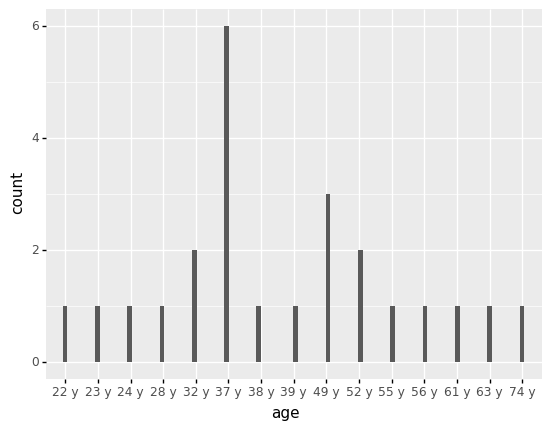

<ggplot: (8762668233226)>

In [16]:
from plotnine import *

(ggplot(metadata, aes("age"))
 + geom_histogram(bins=100)
)

In [17]:
%%capture
# capture removes warning from anndata
# Add age, sex and study to adata.obs (renaming just for the looks)
adata.obs.rename(columns={'file': 'sample_name'}, inplace=True)
adata.obs = pd.merge(adata.obs, metadata, on='sample_name')

In [18]:
# Remove the y from the age column
adata.obs['age'] = adata.obs['age'].map(lambda a: a.split(' ')[0])

### Create pseudobulk

In [19]:
# Normalise
adata_norm = h.get_rawnormalised(adata, sf_col='size_factors', use_log=False, use_raw=True)

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.


In [20]:
# Creat pseudobulk per sample
x_sum = []
obs_sum = []
for group, data in adata_norm.obs.groupby(['sample_name', 'age', 'sex', 'study']):
    x_sum.append(np.array(adata_norm[data.index, :].X.sum(axis=0)).ravel())
    obs_sum.append({'sample':str(group[0]), 'age':str(group[1]), 'sex':str(group[2]), 'study':str(group[3])})
x_sum = pd.DataFrame(np.array(x_sum),columns=adata_norm.var_names)
obs_sum = pd.DataFrame(obs_sum)

In [21]:
print(x_sum.shape)
print(obs_sum.shape)

(24, 15022)
(24, 4)


### Differential Expression

In [22]:
group = 'sample'

In [23]:
%%R -i x_sum -i obs_sum -i group
y <- DGEList(counts=t(x_sum), samples=obs_sum)
print(dim(y))

[1] 15022    24


In [24]:
%%R
keep <- filterByExpr(y, group=y$samples[, group])
y <- y[keep, , keep.lib.sizes=FALSE]
print(dim(y))

[1] 13387    24


In [25]:
%%R
y <- calcNormFactors(y)

In [26]:
dmat_loc = pd.DataFrame(index=obs_sum.index)
dmat_loc['Intercept'] = 1

condition = 'age'
for val_idx,val in enumerate(
    sorted([cl for cl in obs_sum[condition].unique()])):
    dmat_loc.loc[obs_sum[condition]==val,condition]=val

condition = 'sex'
for val_idx,val in enumerate(
    sorted([cl for cl in obs_sum[condition].unique() if cl!='male'])):
    dmat_loc.loc[obs_sum[condition]==val,condition+'_'+str(val)]=1

dmat_loc['male:age'] = 0.0
dmat_loc['female:age'] = 0.0

for index, row in dmat_loc.iterrows():
    if dmat_loc.at[index, 'sex_female'] == 1.0:
        dmat_loc.at[index, 'female:age'] = row['age']
    else:
        dmat_loc.at[index, 'male:age'] = row['age']

condition='study'
for val_idx,val in enumerate(
    sorted([cl for cl in obs_sum[condition].unique() if cl!='UPR'])):
    dmat_loc.loc[obs_sum[condition]==val,condition+'_'+str(val)]=1
    
dmat_loc.fillna(0,inplace=True)
dmat_loc=dmat_loc.astype('float')

del(dmat_loc['age'])

print('dmat_loc')
display(dmat_loc)

dmat_loc


,Intercept,sex_female,male:age,female:age,study_human_healthy,study_human_spikein_drug
0,1.0,1.0,0.0,74.0,1.0,0.0
1,1.0,1.0,0.0,32.0,0.0,0.0
2,1.0,1.0,0.0,55.0,0.0,0.0
3,1.0,1.0,0.0,49.0,0.0,0.0
4,1.0,0.0,56.0,0.0,0.0,0.0
5,1.0,0.0,23.0,0.0,0.0,0.0
6,1.0,0.0,52.0,0.0,0.0,0.0
7,1.0,0.0,52.0,0.0,0.0,0.0
8,1.0,0.0,49.0,0.0,0.0,0.0
9,1.0,1.0,0.0,37.0,0.0,0.0


In [27]:
# Add design to R and name rows
ro.globalenv['design']=dmat_loc
ro.r('row.names(design)<-row.names(y$samples)')
ro.r('design')

,Intercept,sex_female,male:age,female:age,study_human_healthy,study_human_spikein_drug
0,1.0,1.0,0.0,74.0,1.0,0.0
1,1.0,1.0,0.0,32.0,0.0,0.0
2,1.0,1.0,0.0,55.0,0.0,0.0
3,1.0,1.0,0.0,49.0,0.0,0.0
4,1.0,0.0,56.0,0.0,0.0,0.0
5,1.0,0.0,23.0,0.0,0.0,0.0
6,1.0,0.0,52.0,0.0,0.0,0.0
7,1.0,0.0,52.0,0.0,0.0,0.0
8,1.0,0.0,49.0,0.0,0.0,0.0
9,1.0,1.0,0.0,37.0,0.0,0.0


In [28]:
%%R
# Robust dispersion 
y <- estimateGLMRobustDisp(y, design)

In [29]:
%%R
# Fit - GLM not QL as used robust dispersion
fit <- glmFit(y, design)

In [30]:
%R fit$design

array([[ 1.,  1.,  0., 74.,  1.,  0.],
       [ 1.,  1.,  0., 32.,  0.,  0.],
       [ 1.,  1.,  0., 55.,  0.,  0.],
       [ 1.,  1.,  0., 49.,  0.,  0.],
       [ 1.,  0., 56.,  0.,  0.,  0.],
       [ 1.,  0., 23.,  0.,  0.,  0.],
       [ 1.,  0., 52.,  0.,  0.,  0.],
       [ 1.,  0., 52.,  0.,  0.,  0.],
       [ 1.,  0., 49.,  0.,  0.,  0.],
       [ 1.,  1.,  0., 37.,  0.,  0.],
       [ 1.,  0., 39.,  0.,  0.,  0.],
       [ 1.,  0., 28.,  0.,  0.,  0.],
       [ 1.,  0., 49.,  0.,  0.,  0.],
       [ 1.,  1.,  0., 24.,  1.,  0.],
       [ 1.,  0., 61.,  0.,  1.,  0.],
       [ 1.,  0., 63.,  0.,  1.,  0.],
       [ 1.,  1.,  0., 22.,  1.,  0.],
       [ 1.,  0., 38.,  0.,  0.,  1.],
       [ 1.,  0., 32.,  0.,  0.,  1.],
       [ 1.,  0., 37.,  0.,  0.,  1.],
       [ 1.,  0., 37.,  0.,  0.,  1.],
       [ 1.,  0., 37.,  0.,  0.,  1.],
       [ 1.,  0., 37.,  0.,  0.,  1.],
       [ 1.,  0., 37.,  0.,  0.,  1.]])

In [31]:
sex = ro.r('glmLRT(fit, coef=2)$table')
sex['padj'] = multipletests(sex["PValue"].values, alpha=0.05, method='fdr_bh')[1]
sex['-log_padj'] = -np.log10(sex['padj'])
sex['marked'] = sex.index == 'DEFB4A'
sex.sort_values(['padj'])
#sex.sort_values(['logFC'], ascending=0)

,logFC,logCPM,LR,PValue,padj,-log_padj,marked
RPS4Y1,-13.137752,8.768376,36.201224,1.779587e-09,0.000024,4.622997,False
CTU1,-8.366315,1.340780,31.212200,2.313079e-08,0.000103,3.986248,False
DEFB4A,-31.964563,-0.799294,31.557048,1.936662e-08,0.000103,3.986248,True
SERPINE2,-4.639414,4.258407,26.867037,2.179445e-07,0.000729,3.137031,False
RNF187,-4.634564,4.929579,23.524727,1.233187e-06,0.003302,2.481258,False
...,...,...,...,...,...,...,...
BAHD1,-0.055103,1.973370,0.007979,9.288212e-01,1.000000,-0.000000,False
DDO,0.449599,0.383854,0.136806,7.114768e-01,1.000000,-0.000000,False
CDK19,0.145254,1.980755,0.042983,8.357575e-01,1.000000,-0.000000,False
CEP57L1,0.094369,2.711766,0.026713,8.701701e-01,1.000000,-0.000000,False


In [32]:
male_age = ro.r('glmLRT(fit, coef=3)$table')
male_age['padj'] = multipletests(male_age["PValue"].values, alpha=0.05, method='fdr_bh')[1]
male_age['-log_padj'] = -np.log10(male_age['padj'])
male_age['marked'] = male_age.index == 'DEFB4A'
male_age.sort_values(['padj'])

,logFC,logCPM,LR,PValue,padj,-log_padj,marked
UHRF1,-2.142546e-01,-1.988779,3.529454e+01,2.834257e-09,0.000038,4.420877,False
SERPINE2,-7.939525e-02,4.258407,3.353119e+01,7.013041e-09,0.000047,4.328440,False
DEFB4A,-4.636662e-01,-0.799294,2.945483e+01,5.723514e-08,0.000199,3.701666,True
CTU1,-1.216491e-01,1.340780,2.938322e+01,5.938966e-08,0.000199,3.701666,False
MAP2K2,-6.397286e-02,4.266954,2.646076e+01,2.689458e-07,0.000720,3.142622,False
...,...,...,...,...,...,...,...
CEP41,2.672528e-06,3.901987,9.949673e-08,9.997483e-01,1.000000,-0.000000,False
RPH3AL,7.153861e-07,6.124896,5.004368e-09,9.999436e-01,1.000000,-0.000000,False
ARHGEF12,6.723570e-06,4.003873,4.556772e-07,9.994614e-01,1.000000,-0.000000,False
BTD,6.651427e-07,3.855901,4.079890e-08,9.998388e-01,1.000000,-0.000000,False


In [33]:
female_age = ro.r('glmLRT(fit, coef=4)$table')
female_age['padj'] = multipletests(female_age["PValue"].values, alpha=0.05, method='fdr_bh')[1]
female_age['-log_padj'] = -np.log10(female_age['padj'])
female_age['marked'] = female_age.index == 'DEFB4A'
female_age.sort_values(['padj'])

,logFC,logCPM,LR,PValue,padj,-log_padj,marked
DEFB4A,0.093517,-0.799294,34.618881,4.009978e-09,0.000054,4.270175,True
GTSF1,-0.132937,-1.983186,31.852972,1.662950e-08,0.000111,3.953467,False
LDHA,0.041628,4.025231,23.242376,1.428155e-06,0.006373,2.195663,False
HMOX1,0.046989,3.087002,21.181014,4.178836e-06,0.008081,2.092532,False
AC011043.1,-0.101955,5.050690,20.985020,4.628886e-06,0.008081,2.092532,False
...,...,...,...,...,...,...,...
CERCAM,0.000016,3.399265,0.000004,9.985033e-01,1.000000,-0.000000,False
ZBTB21,-0.000036,2.308326,0.000013,9.971133e-01,1.000000,-0.000000,False
SLC25A25,-0.000030,2.768012,0.000020,9.964475e-01,1.000000,-0.000000,False
SHISA5,0.000035,5.048464,0.000040,9.949720e-01,1.000000,-0.000000,False


In [34]:
male_age_vs_female_age = ro.r('glmLRT(fit, contrast=c(0, 0, -1, 1, 0, 0))$table')
male_age_vs_female_age['padj'] = multipletests(male_age_vs_female_age["PValue"].values, alpha=0.05, method='fdr_bh')[1]
male_age_vs_female_age['-log_padj'] = -np.log10(male_age_vs_female_age['padj'])
male_age_vs_female_age['marked'] = male_age_vs_female_age.index == 'DEFB4A'
male_age_vs_female_age.sort_values(['padj'])

,logFC,logCPM,LR,PValue,padj,-log_padj,marked
DEFB4A,0.557184,-0.799294,32.867139,9.867722e-09,0.000117,3.932589,True
SERPINE2,0.099192,4.258407,31.759597,1.744849e-08,0.000117,3.932589,False
ITIH5,0.124316,1.127703,25.638418,4.117595e-07,0.001837,2.735794,False
VIPR2,0.241474,-2.695863,24.491357,7.464394e-07,0.002498,2.602382,False
CTU1,0.134604,1.340780,23.359489,1.343789e-06,0.003598,2.443956,False
...,...,...,...,...,...,...,...
AFG1L,-0.012524,1.298256,0.519555,4.710315e-01,1.000000,-0.000000,False
FOXO3,-0.022435,3.665569,2.858896,9.086983e-02,1.000000,-0.000000,False
ARMC2,0.003936,1.226218,0.055946,8.130219e-01,1.000000,-0.000000,False
MTRES1,-0.004102,4.883582,0.198229,6.561541e-01,1.000000,-0.000000,False


### Analyse results

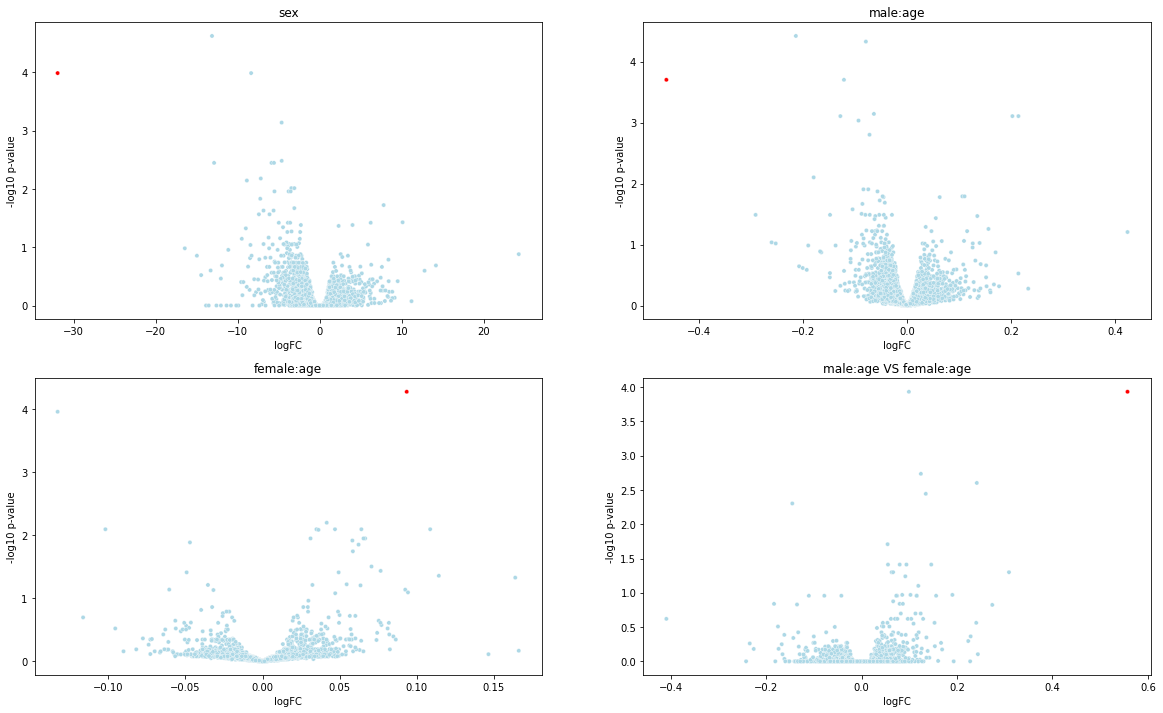

In [35]:
fig = plt.figure(figsize=(20,12))

pal = ['lightblue', 'red']

ax1 = plt.subplot(2, 2, 1)
sb.scatterplot(x='logFC', y='-log_padj', data=sex, size=2, palette=pal, hue='marked', legend=False)
ax1.set_title('sex')

ax2 = plt.subplot(2, 2, 2)
sb.scatterplot(x='logFC', y='-log_padj', data=male_age, size=2, palette=pal, hue='marked', legend=False)
ax2.set_title('male:age')

ax3 = plt.subplot(2, 2, 3)
sb.scatterplot(x='logFC', y='-log_padj', data=female_age, size=2, palette=pal, hue='marked', legend=False)
ax3.set_title('female:age')

ax4 = plt.subplot(2, 2, 4)
sb.scatterplot(x='logFC', y='-log_padj', data=male_age_vs_female_age, size=2, palette=pal, hue='marked', legend=False)
ax4.set_title('male:age VS female:age')

ax1.set_ylabel('-log10 p-value')
ax2.set_ylabel('-log10 p-value')
ax3.set_ylabel('-log10 p-value')
ax4.set_ylabel('-log10 p-value')

plt.show()